# Analyse the result of different smoothing on the initial state relying on WOA09

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [2]:
import gsw as gsw

>> Function definition START

In [3]:
def Arc_Bat(ztype='isol1000') :

        locpath=='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
        locfile='CREG025.L75_domain_cfg.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['bathy_meter'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [4]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=0
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return m

In [5]:
def awtmax_depth (temp,sal,zdim,deptht,ztime=None, zmask=None):
    #%%time 
    if ztime != None : 
        mask = (sal > 33.5) 
        ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    #print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    #reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Hard coded dimensions of the CREG025.L75 configuration 
    if ztime != None : 
        reshape_true_depth=np.reshape(true_depth,(ztime,603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['time_counter','y','x'])
    else: 
        reshape_true_depth=np.reshape(true_depth,(603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])

    
    return temp_map, final_true_depth

In [6]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

In [7]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

In [8]:
def func_FWC(zMy_var1S,ztmask,ze3): 
    Sref=34.8
    ze33Dtime=ze3*ztmask
    ze33Dtime=xr.where(zMy_var1S > Sref, 0.e0,ze33Dtime)
    fwc3D=((Sref - zMy_var1S) / Sref ) * ze33Dtime
    fwc2D=xr.where(ztmask[0,:,:] == 0., np.nan, np.sum(fwc3D,axis=0))
    return fwc2D

In [9]:
def HeatContent(zvarT,ztmask,ze3):
    rho0=1025.  ; rcp = 3991.86795711963
    hct3D=zvarT*ze3*ztmask
    hct2D=xr.where(ztmask[0,:,:] == 0., np.nan, np.sum(hct3D,axis=0)*rho0*rcp)
    return hct2D  

In [10]:
def SA_CT(zPSU,zTPOT,zpressure,zlon,zlat):
    zSA=gsw.conversions.SA_from_SP(zPSU,zpressure,zlon,zlat)
    zCT=gsw.conversions.CT_from_pt(zSA,zTPOT)
    return zSA, zCT

>> Function definition END

# CREG025.L75  Grid

In [11]:
GRIDPATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75-NEMO420_mesh_mask.nc',drop_variables=["x", "y"] )
ds_grd
tmask2D=ds_grd['tmask'].isel(nav_lev=0,time_counter=0)

# CREG025.L75  Bathymetry

In [12]:
locpath='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)
fieldbat

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, z: 75, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/42)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    ...            ...
    e3w_0         (t, z, y, x) float64 ...
    e3uw_0        (t, z, y, x) float64 ...
    e3vw_0        (t, z, y, x) float64 ...
    bottom_level  (t, y, x) int32 ...
    top_level     (t, y, x) int32 ...
    bathy_meter   (t, y, x) float32 ...
Attributes:
    file_name:  domain_cfg.nc
    TimeStamp:  08/07/2019 18:14:20 +0200

# Read the full years input Data processed by the Arctic Monitoring

In [13]:
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
filein='CREG025.L75-NEMO420_OCEinit_gridT.nc'
ds_init=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])
ds_init.coords['nav_lat']=fieldbat['nav_lat']
ds_init.coords['nav_lon']=fieldbat['nav_lon']
ds_init

<xarray.Dataset>
Dimensions:       (nav_lev: 75, time_counter: 1, y: 603, x: 528)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/18)
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    vomecrty      (time_counter, nav_lev, y, x) float64 ...
    vovecrtz      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    sowaflup      (time_counter, y, x) float64 ...
    sohefldo      (time_counter, y, x) float64 ...
    soshfldo      (time_counter, y, x) float64 ...
    soicecov      (time_counter, y, x) float64 ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
Attributes:
    file_name:  output.init.nc
    TimeStamp:  24/10/2022 15:19:27 -0000

>>> ## Conversion from PSU/Tpot to SA/CT

In [14]:
# Define a pressure from depth
pressure=gsw.p_from_z(-ds_init['nav_lev'],ds_init['nav_lat'])

In [15]:
# Conversion from potential temperature and Practical Salinity to Conservative Temperature and Absolute Salinity 
ds_init['SA']=gsw.conversions.SA_from_SP(ds_init['vosaline'],pressure,ds_init['nav_lon'],ds_init['nav_lat'])
ds_init['CT']=gsw.conversions.CT_from_pt(ds_init['SA'],ds_init['votemper'])

In [16]:
ds_SMX=xr.Dataset()
ds_SMX['SA']=(('z','y','x'),ds_init['SA'].isel(time_counter=0).data)
ds_SMX['CT']=(('z','y','x'),ds_init['CT'].isel(time_counter=0).data)
ds_SMX.coords['nav_lat']=(('y','x'),ds_init['nav_lat'].data)
ds_SMX.coords['nav_lon']=(('y','x'),ds_init['nav_lon'].data)
ds_SMX.coords['nav_lev']=(('z'),ds_init['nav_lev'].data)
ds_SMX['tmask']=(('z','y','x'),ds_grd['tmask'].isel(time_counter=0).data)
ds_SMX['e3t_0']=(('z','y','x'),ds_grd['e3t_0'].isel(time_counter=0).data)
ds_SMX

<xarray.Dataset>
Dimensions:  (z: 75, y: 603, x: 528)
Coordinates:
    nav_lat  (y, x) float32 25.36 25.36 25.36 25.36 ... 55.16 55.09 55.02 54.95
    nav_lon  (y, x) float32 -93.75 -93.5 -93.25 -93.0 ... 102.4 102.2 102.0
    nav_lev  (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: z, y, x
Data variables:
    SA       (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CT       (z, y, x) float64 0.01528 0.01528 0.01528 ... 0.01528 0.01528
    tmask    (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    e3t_0    (z, y, x) float64 1.024 1.024 1.024 1.024 1.024 ... 0.0 0.0 0.0 0.0

In [17]:
DATA_PATH='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
filein='CREG025.L75-NEMO420DIN_OCEinit_gridT_SM10.nc'
ds_s10w3=xr.open_dataset(DATA_PATH+filein,drop_variables=["x", "y"])

lSA, lCT=SA_CT(ds_s10w3['vosaline'].isel(time_counter=0),ds_s10w3['votemper'].isel(time_counter=0),pressure,ds_init['nav_lon'],ds_init['nav_lat'])
ds_SMX['SA_s10w3']=(('z','y','x'),lSA.data)
ds_SMX['CT_s10w3']=(('z','y','x'),lCT.data)

> # Compute the FWC as the vertical heat content 

In [18]:
ds_SMX['FWC']=(('y','x'),func_FWC(ds_SMX.SA,ds_SMX.tmask,ds_SMX.e3t_0).data)
ds_SMX['FWC_s10w3']=(('y','x'),func_FWC(ds_SMX.SA_s10w3,ds_SMX.tmask,ds_SMX.e3t_0).data)

In [19]:
ds_SMX['HCT']=(('y','x'),func_FWC(ds_SMX.CT,ds_SMX.tmask,ds_SMX.e3t_0).data)
ds_SMX['HCT_s10w3']=(('y','x'),func_FWC(ds_SMX.CT_s10w3,ds_SMX.tmask,ds_SMX.e3t_0).data)

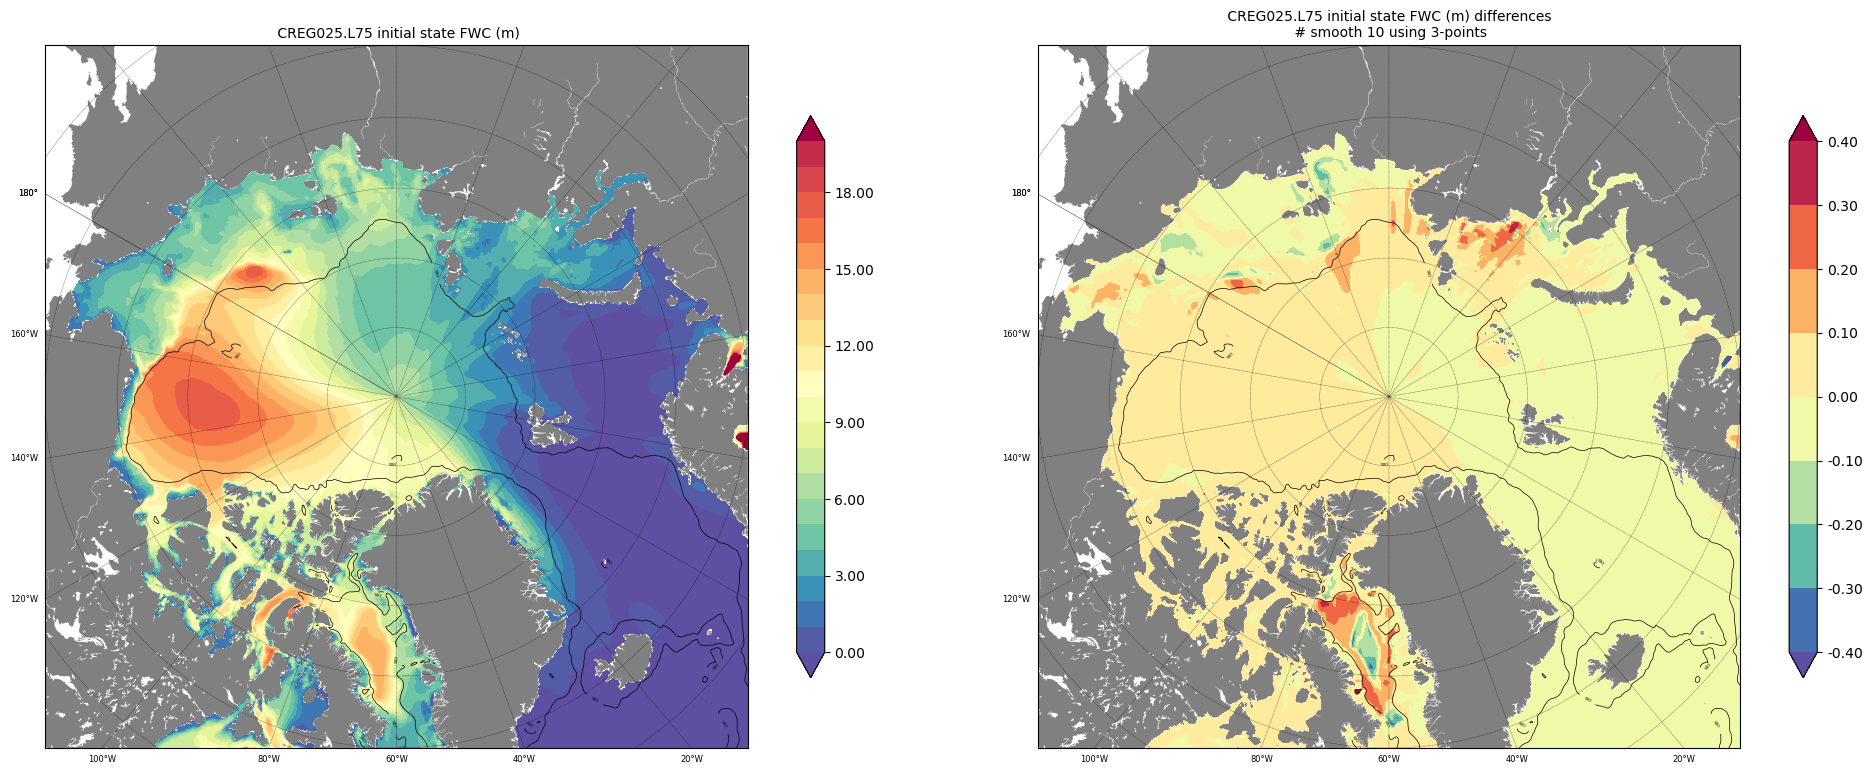

In [20]:
plt.figure(figsize=(20,15))

plt.subplot(221)
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_SMX.nav_lon,ds_SMX.nav_lat,ds_SMX['FWC'],np.arange(0,21),[0.,21.],zmy_cmap='Spectral_r')
plt.title( ' CREG025.L75 initial state FWC (m)',fontsize=10)

plt.subplot(222)
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_SMX.nav_lon,ds_SMX.nav_lat,ds_SMX['FWC_s10w3']-ds_SMX['FWC'],np.arange(0,9)*0.1-0.4,[-.4,0.4],zmy_cmap='Spectral_r')
plt.title( ' CREG025.L75 initial state FWC (m) differences \n # smooth 10 using 3-points',fontsize=10)

plt.tight_layout()

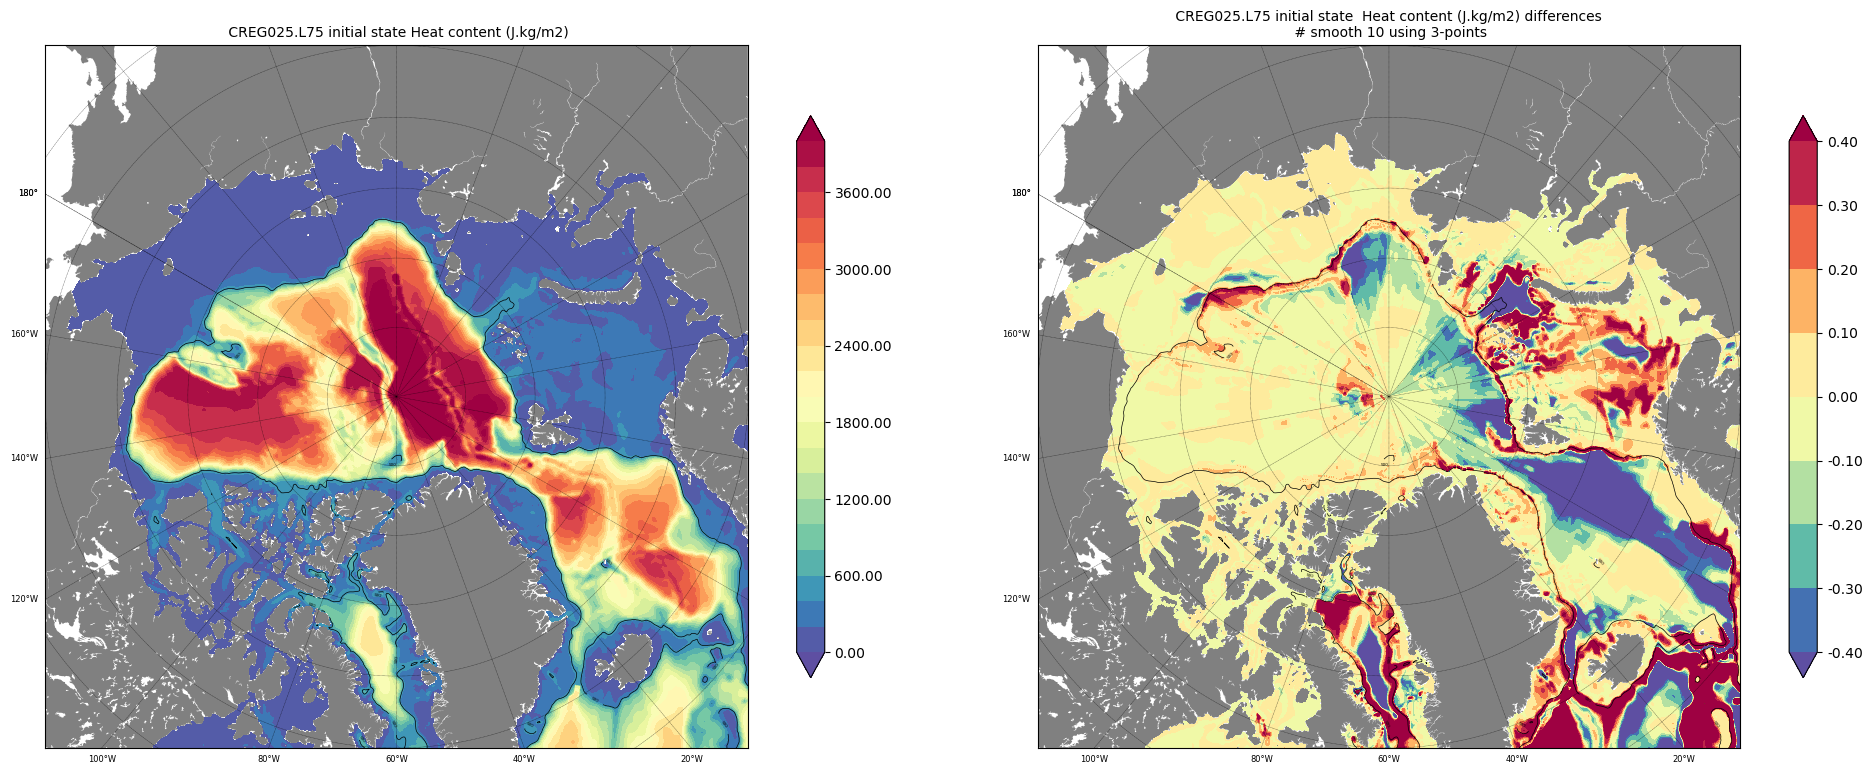

In [21]:
plt.figure(figsize=(20,15))

plt.subplot(221)
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_SMX.nav_lon,ds_SMX.nav_lat,ds_SMX['HCT'],np.arange(0,21)*200.,[0.,4000.],zmy_cmap='Spectral_r')
plt.title( ' CREG025.L75 initial state Heat content (J.kg/m2)',fontsize=10)

plt.subplot(222)
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_SMX.nav_lon,ds_SMX.nav_lat,ds_SMX['HCT_s10w3']-ds_SMX['HCT'],np.arange(0,9)*0.1-0.4,[-.4,0.4],zmy_cmap='Spectral_r')
plt.title( ' CREG025.L75 initial state  Heat content (J.kg/m2) differences \n # smooth 10 using 3-points',fontsize=10)

plt.tight_layout()

# Plot on a map the mooring location

In [14]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

In [9]:
LAPT_sec={'name':"Laptev" ,'jmin': 470,'jmax':520 ,'imin':340}
SANX_sec={'name':"Saint Anna",'imin': 320,'imax':370 ,'jmax':425}

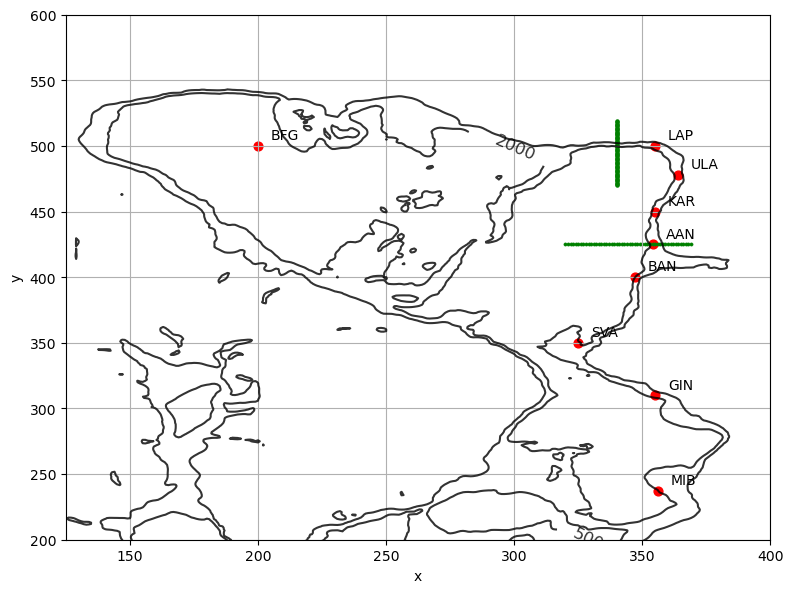

In [23]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)
# Plot the sections
if True:
    All_sec=[SANX_sec]
    for box in All_sec:
            #################
            # ZONAL SECTIONS
            #################
            ji=box['imin'] ;   jj=box['jmax']
            while ji <= box['imax']-1 :
                    plt.scatter(ji,jj,5,linewidth=0.5,color='g')
                    ji+=1

    All_sec=[LAPT_sec]
    for box in All_sec:
            #################
            # MERIDIONAL SECTIONS
            #################
            jj=box['jmin'] ;       ji=box['imin']
            while jj <= box['jmax']-1 :
                    plt.scatter(ji,jj,5,linewidth=1,color='g')
                    jj+=1
